In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
# import statsmodels.api as sm

In [6]:
file_list = []
df_lists = []
season_lists = []
df_season_lists = []

for i in range(7, 21):
    file_list.append("draft/"+str(i)+".csv")

for i in range(7, 22):
    season_lists.append("season/"+str(i)+".csv")


def draft_file_reader(file_list):
    for file in file_list:
        df = pd.read_csv(file)
        clean_data_draft(df)

# remove all the rows that have NaN values in the WS/48 or VORP columns

def clean_data_draft(df):
    df = df.dropna(subset=['WS/48', 'VORP'])
    df_lists.append(df)

def season_file_reader(season_lists):
    for file in season_lists:
        df = pd.read_csv(file, encoding='latin1')
        clean_season_data(df)

def clean_season_data(df):
    # check if the player occurs in the df multiple times, take the first occurence
    df = df.drop_duplicates(subset=['Player'], keep='first')
    df_season_lists.append(df)

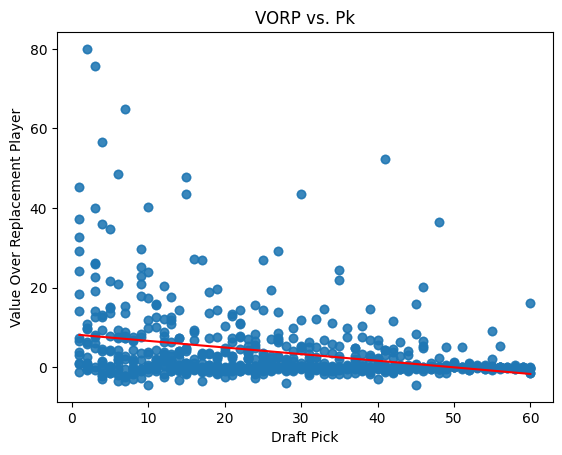

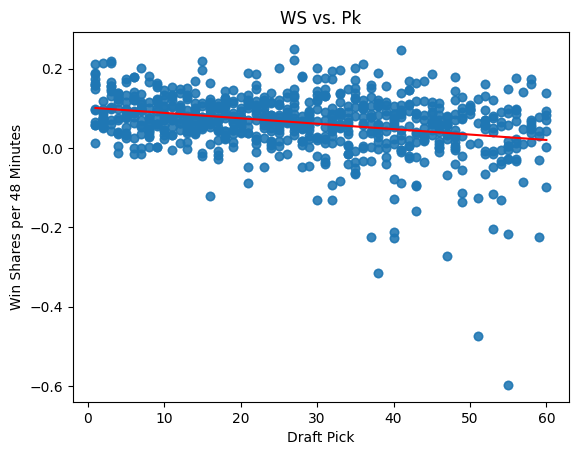

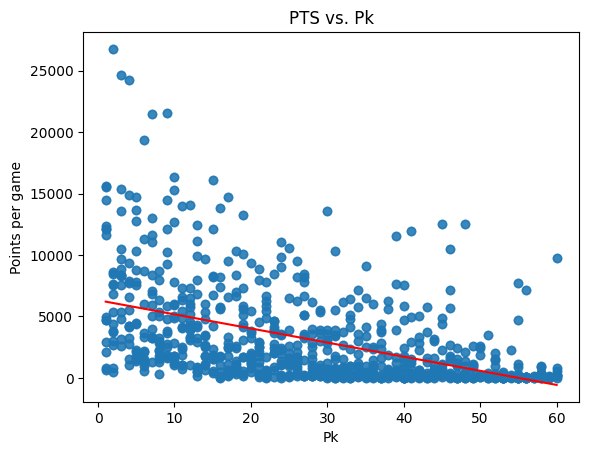

In [10]:
def draft_plot():
    plt.figure(1)
    # Concatenate all the dataframes into one
    df = pd.concat(df_lists, ignore_index=True)

    model_1 = LinearRegression()
    model_1.fit(df['Pk'].values.reshape(-1, 1), df['VORP'])
    y_pred_1 = model_1.predict(df['Pk'].values.reshape(-1, 1))
    plt.plot(df['Pk'], y_pred_1, color='red')

    # X = df['Pk'].values.reshape(-1, 1)
    # X = sm.add_constant(X)
    # Y = df['VORP']
    # model = sm.OLS(Y, X).fit()
    # print(model.summary())
    # plt.plot(X, model.predict(X), color='blue')
    
    plt.scatter(df['Pk'], df['VORP'], alpha=0.5)
    plt.xlabel("Draft Pick")
    plt.ylabel("Value Over Replacement Player")
    plt.title("VORP vs. Pk")
    # plt.savefig("VORP.png")
    plt.show()


    plt.figure(2)
    model_2 = LinearRegression()
    model_2.fit(df['Pk'].values.reshape(-1, 1), df['WS/48'])
    y_pred_2 = model_2.predict(df['Pk'].values.reshape(-1, 1))
    plt.plot(df['Pk'], y_pred_2, color='red')

    plt.scatter(df['Pk'], df['WS/48'], alpha=0.5)
    plt.xlabel("Draft Pick")
    plt.ylabel("Win Shares per 48 Minutes")
    plt.title("WS vs. Pk")
    # plt.savefig("WS48.png")
    plt.show()

    plt.figure(3)
    model_3 = LinearRegression()
    model_3.fit(df['Pk'].values.reshape(-1, 1), df['PTS'])
    y_pred_3 = model_3.predict(df['Pk'].values.reshape(-1, 1))
    plt.plot(df['Pk'], y_pred_3, color='red')

    plt.scatter(df['Pk'], df['PTS'], alpha=0.5)
    plt.xlabel("Pk")
    plt.ylabel("Points per game")
    plt.title("PTS vs. Pk")
    # plt.savefig("PTS.png")
    plt.show()

    return df

draft_file_reader(file_list)  
df = draft_plot()

    

In [12]:
# Group by pick number and calculate mean WS/48 and VORP
grouped = df.groupby('Pk').agg({'PTS.1': 'mean', 'PTS': 'mean','AST.1': 'mean', 'WS/48': 'mean', 'VORP': 'mean'}).reset_index()

# calculate the correlation matrix between draft pick and performance metrics
correlation_matrix = grouped[['Pk', 'PTS', 'WS/48', 'VORP']].corr()

# print the correlation matrix
print("Correlation matrix between draft pick and performance metrics\n", correlation_matrix)


Correlation matrix between draft pick and performance metrics
              Pk       PTS     WS/48      VORP
Pk     1.000000 -0.882619 -0.683460 -0.735113
PTS   -0.882619  1.000000  0.659910  0.917471
WS/48 -0.683460  0.659910  1.000000  0.618772
VORP  -0.735113  0.917471  0.618772  1.000000


In [13]:
# e.g. Null Hypothesis: There is no significant difference in the average WS/48 and VORP 
# between players selected in the top 5 picks (Pk <= 5) and players selected outside 
# the top 10 picks (Pk > 5 and Pk <= 10). If null hypothesis is greater than 0.05,
# then we can not reject the null hypothesis.
print("ttest between groups of 5 picks")
for i in range(0, 11):
# Split the data into two groups based on the Pk value
    top_picks = grouped[(grouped['Pk'] > i * 5) & (grouped['Pk'] <= (i + 1) * 5)]
    other_picks = grouped[(grouped['Pk'] > (i+1)*5) & (grouped['Pk'] <= (i+2)*5)]

    print("ttest group  1 Pk:", i*5, "-", (i+1)*5, "vs" , "group 2, pk: ", (i+1)*5, "-", (i+2)*5)

    # Perform a two-sample t-test on the WS/48 values
    ws_ttest = ttest_ind(top_picks['WS/48'], other_picks['WS/48'])

    # Print the p-value
    print('WS/48 p-value:', ws_ttest.pvalue)

    # Perform a two-sample t-test on the VORP values
    vorp_ttest = ttest_ind(top_picks['VORP'], other_picks['VORP'])

    # Print the p-value
    print('VORP p-value:', vorp_ttest.pvalue)

    # Perform a two-sample t-test on the PTS values
    pts_ttest = ttest_ind(top_picks['PTS'], other_picks['PTS'])

    # Print the p-value
    print('PTS p-value:', pts_ttest.pvalue)

ttest between groups of 5 picks
ttest group  1 Pk: 0 - 5 vs group 2, pk:  5 - 10
WS/48 p-value: 0.13398630094996855
VORP p-value: 0.06725490627035631
PTS p-value: 0.08142460446570043
ttest group  1 Pk: 5 - 10 vs group 2, pk:  10 - 15
WS/48 p-value: 0.6649048335800896
VORP p-value: 0.2438237328843759
PTS p-value: 0.1507986791562946
ttest group  1 Pk: 10 - 15 vs group 2, pk:  15 - 20
WS/48 p-value: 0.03927202522284016
VORP p-value: 0.04548843453913376
PTS p-value: 0.04762621155086901
ttest group  1 Pk: 15 - 20 vs group 2, pk:  20 - 25
WS/48 p-value: 0.6029268694686447
VORP p-value: 0.6589316932132546
PTS p-value: 0.15693166427702046
ttest group  1 Pk: 20 - 25 vs group 2, pk:  25 - 30
WS/48 p-value: 0.8111087957844187
VORP p-value: 0.9477707902527714
PTS p-value: 0.4351050383168582
ttest group  1 Pk: 25 - 30 vs group 2, pk:  30 - 35
WS/48 p-value: 0.2326360916022227
VORP p-value: 0.33206187829203065
PTS p-value: 0.13356138117740074
ttest group  1 Pk: 30 - 35 vs group 2, pk:  35 - 40
WS/48

In [ ]:
def form_player_growth():
    # read the draft dataset
    draft_df = pd.concat(df_lists, ignore_index=True)

    # read the performance dataset
    performance_df = pd.concat(df_season_lists, ignore_index=True)

    # merge the datasets based on player names
    merged_df = pd.merge(draft_df, performance_df, on='Player', how='inner')
    print(merged_df)
    player_dict = {}
    for index, row in merged_df.iterrows():
        player_name = row['Player']
        pts_y = row['PTS_y']
        if player_name in player_dict:
            player_dict[player_name].append(pts_y)
        else:
            player_dict[player_name] = [pts_y]
        # Create a dictionary of player's first year points
    return player_dict

      Rk_x  Pk Tm_x             Player                College   Yrs    G_x  \
0        1   1  POR          Greg Oden             Ohio State   3.0  105.0   
1        1   1  POR          Greg Oden             Ohio State   3.0  105.0   
2        1   1  POR          Greg Oden             Ohio State   3.0  105.0   
3        2   2  SEA       Kevin Durant                  Texas  15.0  981.0   
4        2   2  SEA       Kevin Durant                  Texas  15.0  981.0   
...    ...  ..  ...                ...                    ...   ...    ...   
2894    50  50  ATL        Skylar Mays                    LSU   2.0   61.0   
2895    52  52  SAC  Kenyon Martin Jr.                    NaN   3.0  196.0   
2896    52  52  SAC  Kenyon Martin Jr.                    NaN   3.0  196.0   
2897    59  59  TOR       Jalen Harris                 Nevada   1.0   13.0   
2898    60  60  NOP        Sam Merrill  Utah State University   3.0   38.0   

         MP_x    PTS_x   TRB_x  ...  FT%_y  ORB  DRB  TRB_y  AS

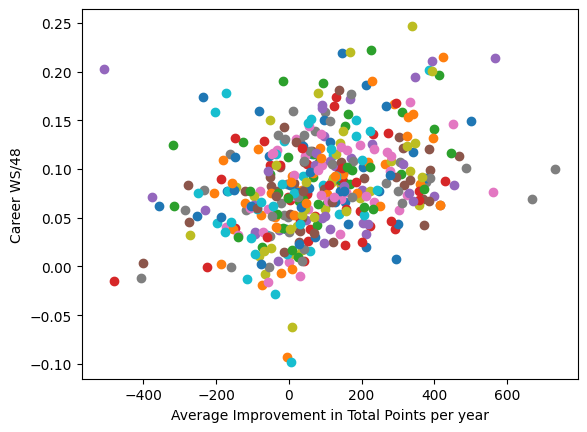

In [ ]:
def average_year_analysis(player_dict):
    draft_df = pd.concat(df_lists, ignore_index=True)
        # Calculate the average improvement of total points each year for each player
    average_improvement_dict = {}
    for player_name, total_points_list in player_dict.items():
        if len(total_points_list) > 2:
            improvement_list = []
            for i in range(2):
                improvement = total_points_list[i+1] - total_points_list[i]
                improvement_list.append(improvement)
            average_improvement = sum(improvement_list) / len(improvement_list)
            average_improvement_dict[player_name] = average_improvement

            # Loop over each player in the dictionary and create a scatter plot
    for player_name, rookie_year in average_improvement_dict.items():
        # Get the WS/48 value for the player
        ws = draft_df.loc[draft_df['Player'] == player_name, 'WS/48'].values[0]

        # Create a scatter plot of rookie year vs WS/48
        plt.scatter(rookie_year, ws, label=player_name)

    # Set the x and y axis labels
    plt.xlabel('Average Improvement in Total Points per year')
    plt.ylabel('Career WS/48')
    plt.show()

draft_file_reader(file_list)  
season_file_reader(season_lists)
player_dict = form_player_growth()
average_year_analysis(player_dict)

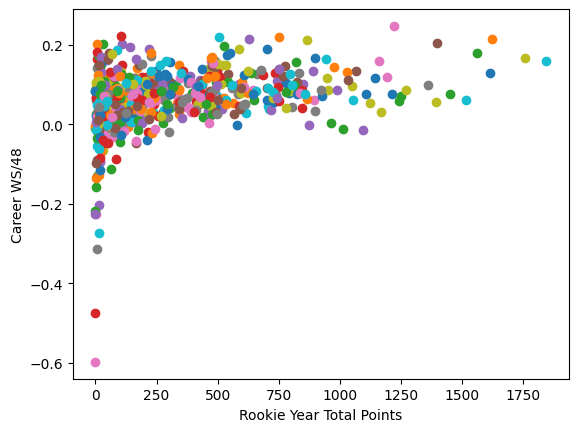

In [ ]:
def rookie_year_analysis(player_dict):
    draft_df = pd.concat(df_lists, ignore_index=True)

    rookie_year_dict = {}
    for player_name, points_list in player_dict.items():
        rookie_year_dict[player_name] = points_list[0]
    
         # Loop over each player in the dictionary and create a scatter plot
    for player_name, rookie_year in rookie_year_dict.items():
        # Get the WS/48 value for the player
        ws = draft_df.loc[draft_df['Player'] == player_name, 'WS/48'].values[0]

        # Create a scatter plot of rookie year vs WS/48
        plt.scatter(rookie_year, ws, label=player_name)

    # Set the x and y axis labels
    plt.xlabel('Rookie Year Total Points')
    plt.ylabel('Career WS/48')
    plt.show()

rookie_year_analysis(player_dict)

     Pk                 Player     WS  VORP  adjusted_WS  adjusted_VORP  \
229  30           Jimmy Butler  104.4  43.5   526.062378     219.192658   
336  27            Rudy Gobert   93.5  29.1   461.457708     143.619458   
73   26            George Hill   70.7  19.3   338.883719      92.509983   
71   24            Serge Ibaka   73.0  15.7   324.742364      69.841851   
72   25          Nicolas Batum   66.4  26.9   307.717173     124.662530   
124  26             Taj Gibson   59.7   7.1   286.157822      34.032170   
324  15  Giannis Antetokounmpo   95.2  47.9   282.766567     142.274354   
385  25           Clint Capela   58.9  14.3   272.959962      66.270415   
214  15          Kawhi Leonard   89.3  43.4   265.242168     128.908288   
105   7          Stephen Curry  126.7  65.0   232.946145     119.506704   
218  19          Tobias Harris   63.6  19.7   230.704002      71.460202   
331  22          Mason Plumlee   51.5  14.3   211.156564      58.631823   
215  16         Nikola Vu

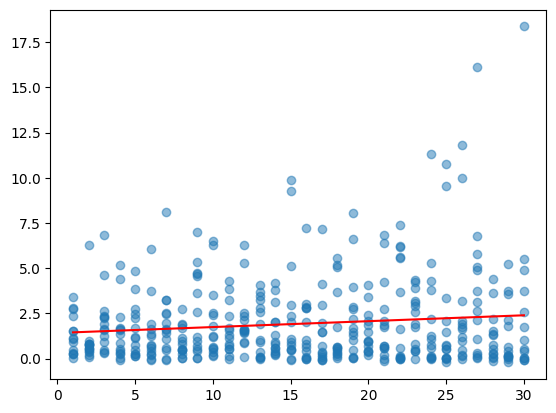

RanksumsResult(statistic=0.29063407132600927, pvalue=0.7713311991886364)


<function matplotlib.pyplot.show(close=None, block=None)>

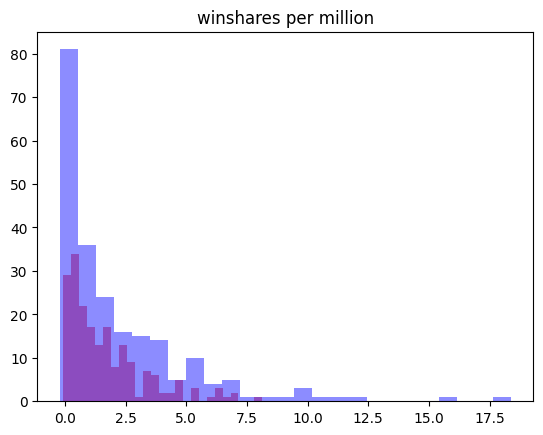

In [ ]:
def makeDraftDF():
    file_list = []
    for i in range(7,21):
        file_list.append("draft/"+str(i)+".csv")

    df_list = []

    for file in file_list:
        df_list.append(pd.read_csv(file).dropna(subset=['WS/48', 'VORP']))

    return pd.concat(df_list, ignore_index=True)

draft = makeDraftDF()
draft = draft[draft["Pk"] <= 30]
draft["lottery"] = draft.apply(lambda x: x["Pk"] <= 14, axis=1)
contractScale = pd.read_csv("rookieContractScale.csv")
contractScale["total"] = contractScale.apply(lambda x: x["year1"]+x["year2"]+x["year3"],axis=1)
firstpickValue = 28631600
contractScale["scale"] = contractScale.apply(lambda x: x["total"]/firstpickValue,axis=1)
contractScale["millions"] = contractScale.apply(lambda x: x["total"]/1000000,axis=1)

scale = contractScale["scale"].values.tolist()
money = contractScale["millions"].values.tolist()
# scale[:5]
# money[:5]

draft["adjusted_WS"] = draft.apply(lambda x: x["WS"]/scale[x["Pk"]-1],axis=1)
draft["adjusted_VORP"] = draft.apply(lambda x: x["VORP"]/scale[x["Pk"]-1],axis=1)
draft["WS_per_million"] = draft.apply(lambda x: x["WS"]/money[x["Pk"]-1],axis=1)
draft["VORP_per_million"] = draft.apply(lambda x: x["VORP"]/money[x["Pk"]-1],axis=1)

asdf = draft[["Pk", "Player", "WS", "VORP", "adjusted_WS", "adjusted_VORP", "WS_per_million", "VORP_per_million"]]
asdf = asdf.sort_values(by="adjusted_WS", ascending=False)

print(asdf.head(20))

model = LinearRegression()
model.fit(draft['Pk'].values.reshape(-1, 1), draft["WS_per_million"])
predicted_WS_per_million = model.predict(draft['Pk'].values.reshape(-1, 1))
    
plt.plot(draft['Pk'], predicted_WS_per_million, color='red')
plt.scatter(draft["Pk"], draft["WS_per_million"], alpha=0.5)
plt.show()

from scipy.stats import ranksums

lottery = draft[draft["lottery"] == True]["WS_per_million"]
notlottery = draft[draft["lottery"] == False]["WS_per_million"]
ranksumResult = ranksums(lottery,notlottery)
print(ranksumResult)

plt.title("winshares per million")
plt.hist(lottery, bins=25, alpha=0.45, color='red')
plt.hist(notlottery, bins=25, alpha=0.45, color='blue')
plt.show